# Entrenamiento de modelos

## Liberías

In [1]:
# librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import string
#from collections import Counter

'''# librerias de nlp
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Word
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer'''

# formateo de datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD



# modelos de sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from scipy.sparse import vstack
from scipy.sparse import hstack

# searching for hyperparameters
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# metricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

# guardar los modelos
from joblib import dump, load

## Vamos a iniciar una función que calcule y muestre las métricas de los modelos

In [2]:
def print_metrics(y_test, yhat):
    # Calcula y muestra métricas 
    print("Jaccard Index:", jaccard_score(y_test, yhat, average="macro"))
    print("Accuracy:", accuracy_score(y_test, yhat))
    print("Precisión:", precision_score(y_test, yhat, average="macro"))
    print("Recall:", recall_score(y_test, yhat, average="macro"))
    print("F1-score:", f1_score(y_test, yhat, average="macro"))
    
    # Calcula y muestra la matriz de confusión
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [3]:
df = pd.read_csv("Data/fake_news_after_eda.csv")

In [4]:
# Inicializamos un objeto CountVecrtorizer()
count_vectorizer = CountVectorizer(max_features = 5000)

# tomamos el texto de las noticias
frases = df['text'].to_numpy()

# creamos una matriz sparse con los datos
bag = count_vectorizer.fit_transform(frases)

bag

<68962x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 14484719 stored elements in Compressed Sparse Row format>

In [5]:
# Inicializamos un objeto CountVecrtorizer()
count_vectorizer = CountVectorizer(max_features = 5000)

# tomamos el texto de las noticias
frases = (df['title'] + df['text']).to_numpy()

# creamos una matriz sparse con los datos
bag = count_vectorizer.fit_transform(frases)

bag

<68962x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 14608952 stored elements in Compressed Sparse Row format>

A medida que avancemos vamos a ir borrando variables para no sobrecargar la memoria.

In [6]:
del(count_vectorizer)

In [7]:
# usamos tfidf para ajustar las apariciones
tfidf = TfidfTransformer()
bag_tfidf = tfidf.fit_transform(bag).toarray()

In [8]:
del(tfidf)
del(bag)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(bag_tfidf, df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)

In [10]:
del(bag_tfidf)

In [11]:
# aplicamos pca con svd que funciona en matrices sparse
svd = TruncatedSVD(n_components = 500, n_iter=7, random_state=42)
svd.fit(X_train)

TruncatedSVD(n_components=500, n_iter=7, random_state=42)

In [12]:
X_train_pca = svd.transform(X_train)
X_test_pca = svd.transform(X_test)

## Random Forest

In [ ]:
model = RandomForestClassifier(verbose = 2, n_jobs = 4)
model.fit(X_train_pca, y_train)

# guardamos el modelo
dump(model, 'models/random_forest.joblib')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Jaccard Index: 0.8193726582964025
Accuracy: 0.9007201894726666
Precisión: 0.9008801319651177
Recall: 0.9009138187665844
F1-score: 0.9007199665745992


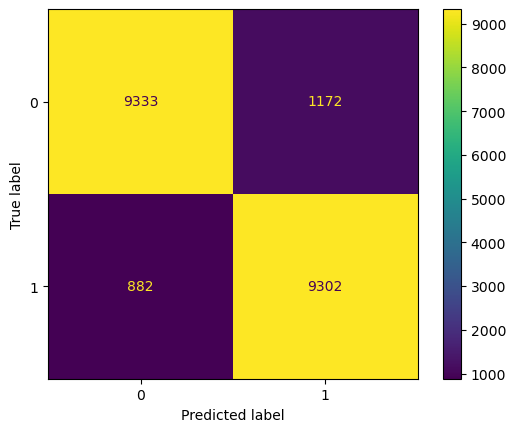

In [16]:
# cargamos el modelo y predecimos
model = load('models/random_forest.joblib')
yhat = model.predict(X_test_pca)

# mostramos las métricas
print_metrics(y_test, yhat)

## Búsqueda de los mejores hiperparámetros con BayesSearch.

In [ ]:
np.int = int
opt = BayesSearchCV(
    RandomForestClassifier(),
    {"criterion": Categorical(['gini', 'entropy', 'log_loss']),
    "n_estimators": Integer(10, 500),
     "min_samples_split": Integer(2, 15),
     "min_samples_leaf": Integer(1, 10),
     "min_impurity_decrease": Real(0, 1),
     "min_weight_fraction_leaf": Real(0, 0.5),
     "max_features": Categorical(['sqrt', 'log2', None]),
    },
    n_jobs=4,
    random_state=42,
    verbose = 2)
bayes_search = opt.fit(X_train_pca, y_train)
dump(bayes_search, 'models/bayes_search_RandomForestClassifier.joblib')

Después de calcular todas las posibilidades para los parámetros dados, la que mejor resultado ha dado ha sido

`Mejores hiperparámetros:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`

In [13]:
model = RandomForestClassifier(bootstrap = True,
                               verbose = 2,
                               n_jobs = 4,
                               max_depth=None,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               n_estimators=300)
model.fit(X_train_pca, y_train)

# guardamos el modelo
dump(model, 'models/bayes_search_RandomForestClassifier.joblib') 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.3s


building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.3min


building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.6min finished


['models/bayes_search_RandomForestClassifier.joblib']

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s


Jaccard Index: 0.8278101805488587
Accuracy: 0.9057953501860893
Precisión: 0.906159933165153
Recall: 0.9060629631346762
F1-score: 0.9057943914796793


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.4s finished


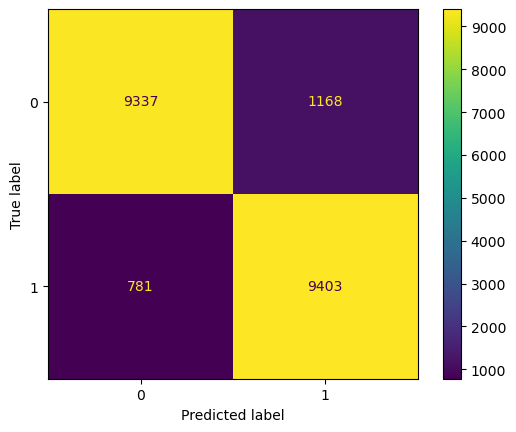

In [14]:
# cargamos el mejor modelo random forest
best_random_forest = load('models/bayes_search_RandomForestClassifier.joblib')

yhat = best_random_forest.predict(X_test_pca)
print_metrics(y_test, yhat)

## Gradient Boosting


In [15]:
# Crea una instancia del modelo GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=2)

# Entrena el modelo
model.fit(X_train_pca, y_train)

# guardamos el modelo
dump(model, 'gradient_boosting.joblib') 

      Iter       Train Loss   Remaining Time 
         1           1.3164           17.33m
         2           1.2590           17.20m
         3           1.2104           16.98m
         4           1.1666           16.81m
         5           1.1300           16.62m
         6           1.0951           16.46m
         7           1.0661           16.27m
         8           1.0389           16.08m
         9           1.0152           15.90m
        10           0.9935           15.72m
        11           0.9747           15.53m
        12           0.9573           15.37m
        13           0.9394           15.18m
        14           0.9235           15.01m
        15           0.9100           14.82m
        16           0.8971           14.65m
        17           0.8857           14.47m
        18           0.8745           14.30m
        19           0.8640           14.12m
        20           0.8556           13.95m
        21           0.8454           13.77m
        2

['gradient_boosting.joblib']

In [15]:
# guardamos el modelo
dump(gb_model, 'gradient_boosting.joblib') 

['gradient_boosting.joblib']

Jaccard Index: 0.7842758500377541
Accuracy: 0.8792316022411601
Precisión: 0.8802907261227493
Recall: 0.8789577347017881
F1-score: 0.8790808202099087


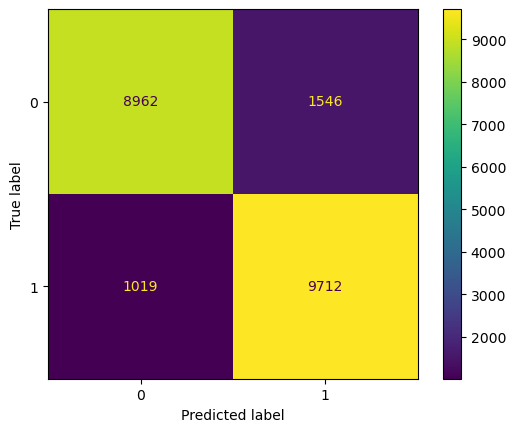

In [16]:
# cargamos el modelo y predecimos
model = load('gradient_boosting.joblib')
yhat = model.predict(X_test_pca)

# mostramos las métricas
print_metrics(y_test, yhat)

Conclusión: el modelo GradientBoostingClassifier está funcionando bastante bien en base a estas métricas. Tiene una cierta inclinación hacia clasificar como falsas, por lo que aumenta el número de falsas acertadas respecto al RandomForest, pero también aumenta significativamente el número de falsas mal detectadas. Este sesgo produce un aumento de la _precision_ y una disminución del _recall_. Además, el tiempo de entrenamiento es significativamente mayor sin aumentar la precisión con respecto al RandomForest.

# Naive Bayes

In [16]:
# Entrenamiento del modelo
model = MultinomialNB()
model.fit(X_train, y_train)

# Guardar el modelo en un archivo
dump(model, 'models/multi_naive_bayes.joblib')

['models/multi_naive_bayes.joblib']

Jaccard Index: 0.7220215154785152
Accuracy: 0.8387871368708508
Precisión: 0.839992160782354
Recall: 0.8384687632503294
F1-score: 0.8385399650483112


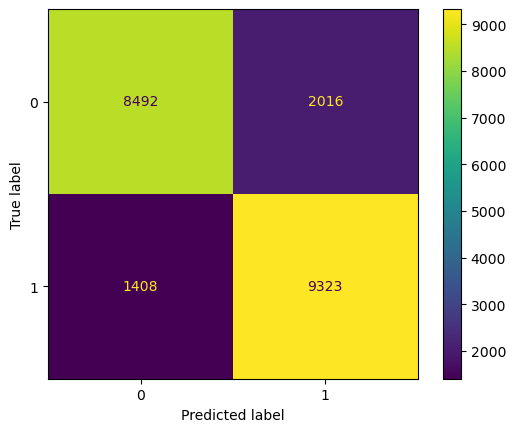

In [32]:
model = load('models/multi_naive_bayes.joblib')
yhat = model.predict(X_test)

# Calcula y muestra métricas de evaluación
print_metrics(y_test, yhat)

Conclusión: este modelo tiene un desempeño peor que el modelo anterior.

## KNeighborsClassifier

In [33]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_pca, y_train)

dump(model, 'models/kneighbors_classifier.joblib') 

['models/kneighbors_classifier.joblib']

Jaccard Index: 0.7624106426054245
Accuracy: 0.8652008098309714
Precisión: 0.8651821584823314
Recall: 0.8651992968370688
F1-score: 0.8651893291332406


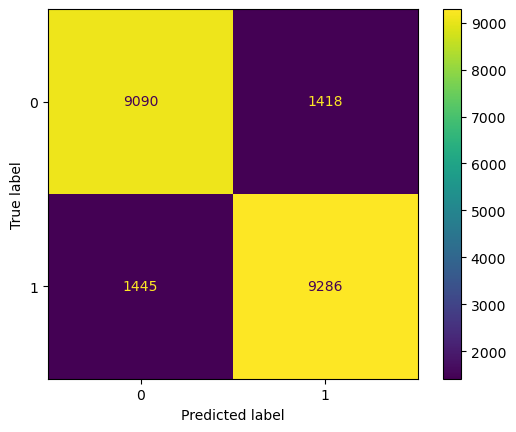

In [35]:
model = load('models/kneighbors_classifier.joblib')
yhat = model.predict(X_test_pca)

# Calcula y muestra métricas de evaluación
print_metrics(y_test, yhat)

## AdaBoostClassifier

In [ ]:
model = AdaBoostClassifier(n_estimators = 100)
model.fit(X_train_pca, y_train)

dump(model, 'models/model_ada_boost_classifier.joblib') 

Jaccard Index: 0.7811869994529365
Accuracy: 0.8772248625477588
Precisión: 0.8772599722173721
Sensibilidad: 0.8770710391862211
F1-score: 0.8771444731071429


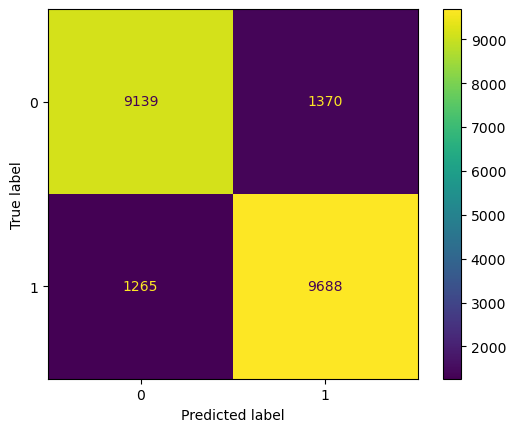

In [28]:
model = load('models/model_ada_boost_classifier.joblib')
yhat = model.predict(X_test_pca)

# Calcula y muestra métricas de evaluación
print_metrics(y_test, yhat)

Llegamos a la conclusión de que el mejor modelo para predecir la veracidad es el RandomForest.